In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
import h5py
import os
import sys
sys.path.append('../utils/')
from plotting_fns import normalize_images, display_images

cutouts (53464, 9, 64, 64)
dec (53464,)
ra (53464,)
zspec (53464,)
zspec_err (53464,)


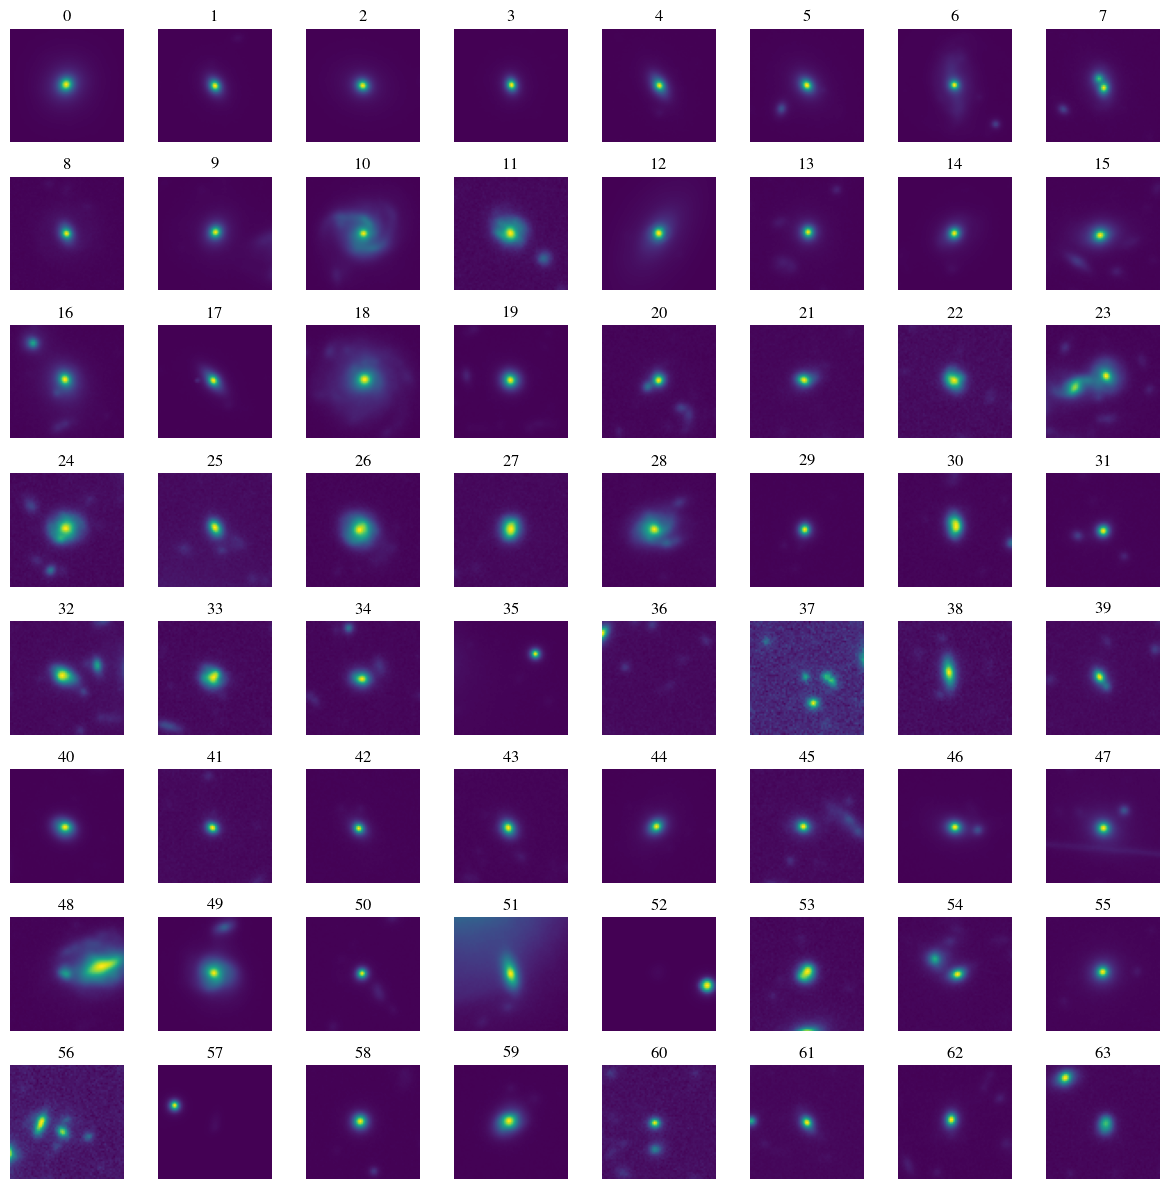

cutouts (9264, 9, 64, 64)
dec (9264,)
ra (9264,)
zspec (9264,)
zspec_err (9264,)


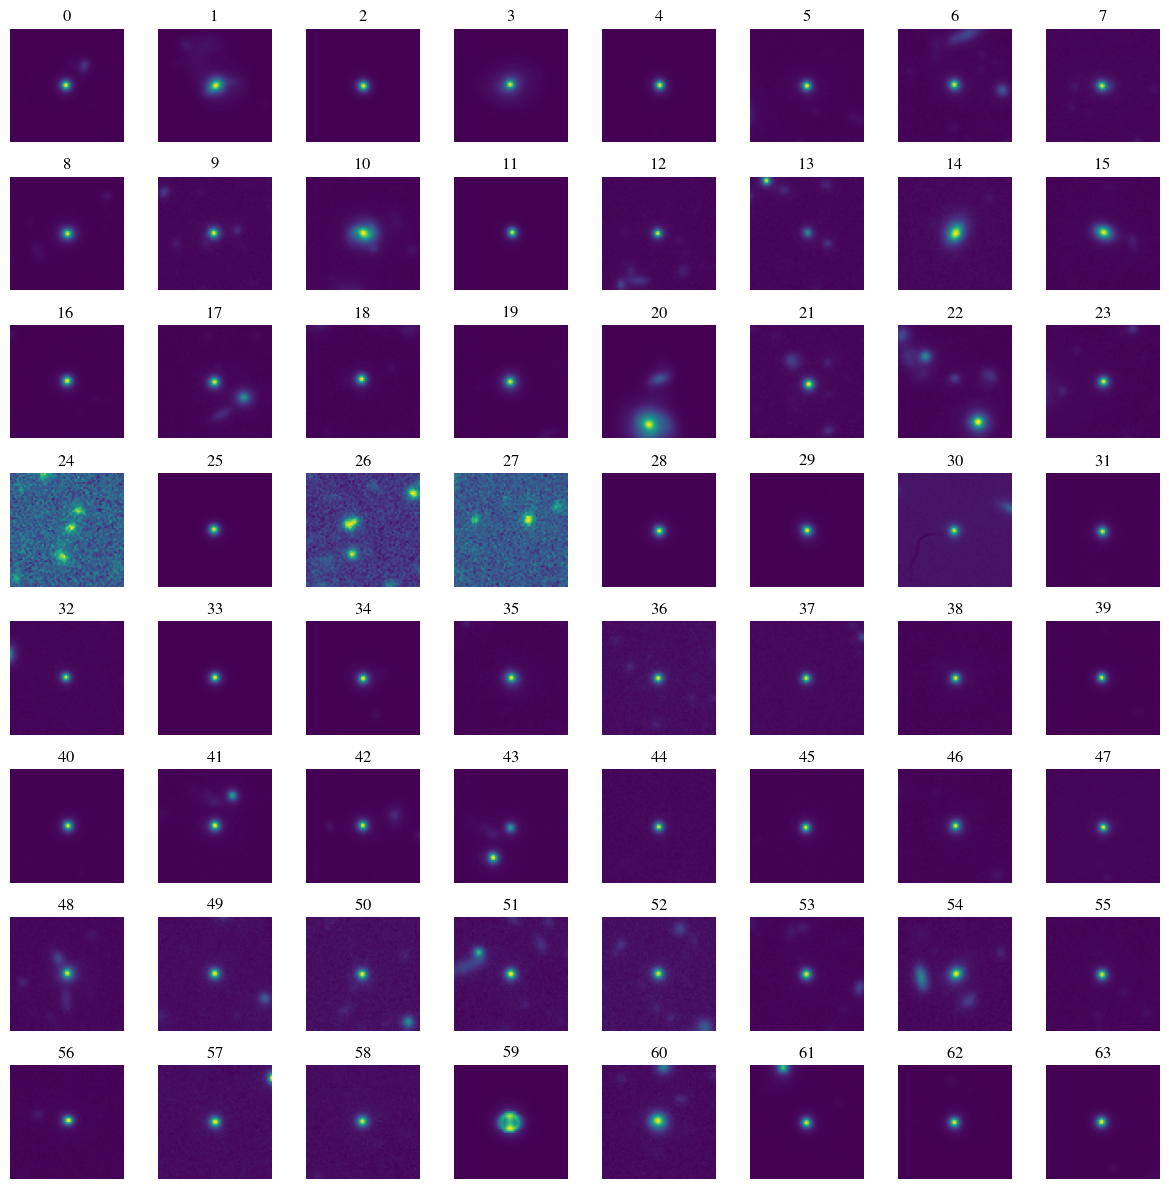

cutouts (25589, 9, 64, 64)
dec (25589,)
ra (25589,)
zspec (25589,)
zspec_err (25589,)


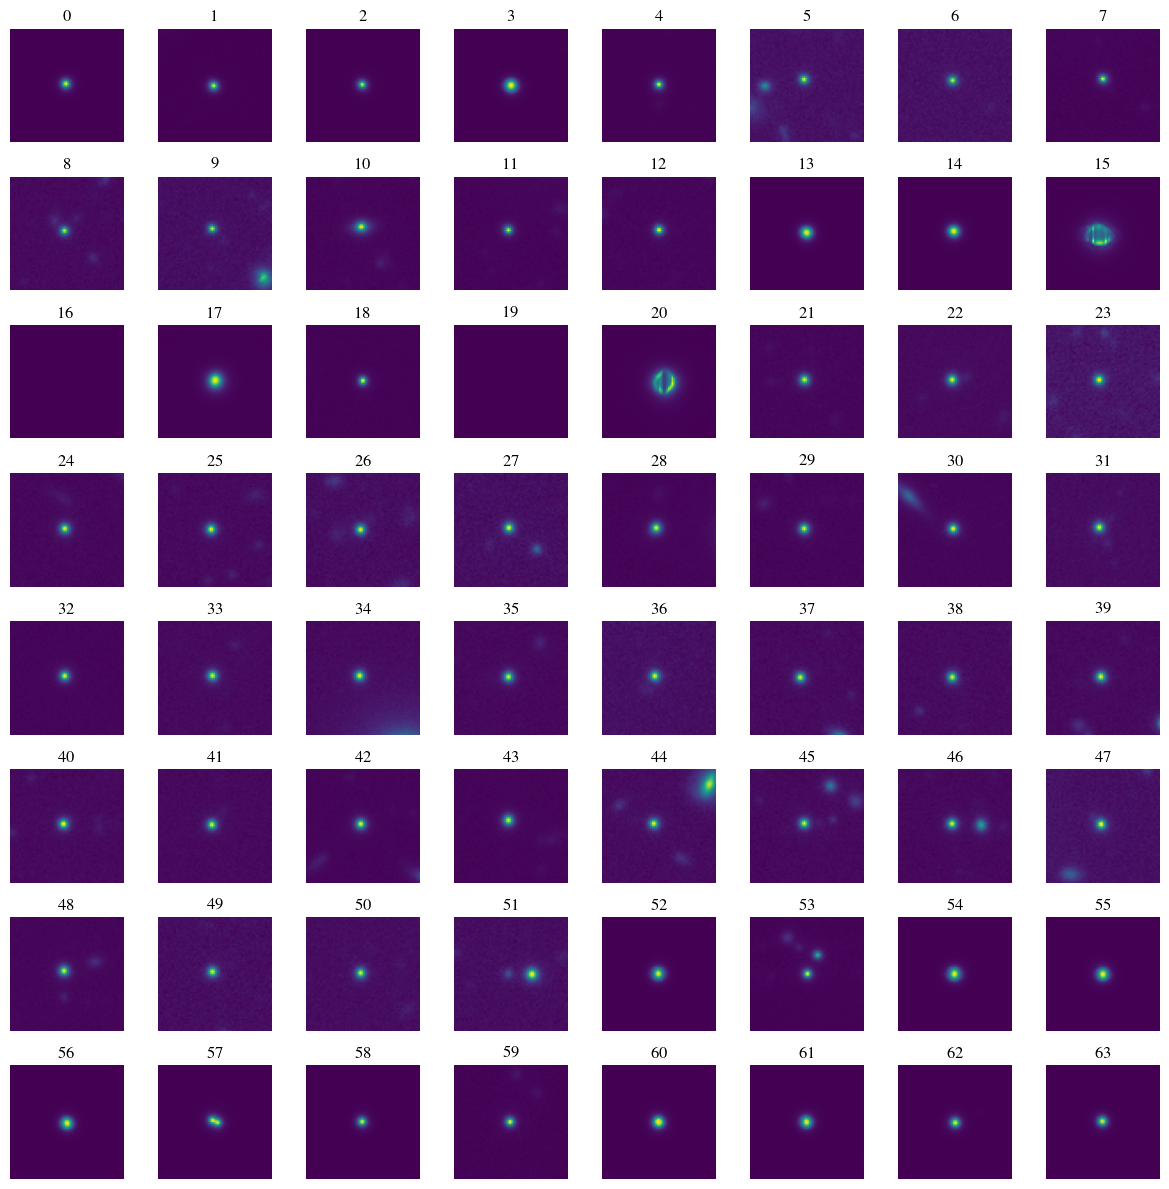

In [3]:
channel = 1
data_dir = '/arc/projects/ots/HSC_h5/'
#fns = ['HSC_dud_galaxy_calexp_GIRYZ7610_64_new.h5',
#       'HSC_dud_qso_calexp_GIRYZ7610_64_new.h5',
#       'HSC_dud_star_calexp_GIRYZ7610_64_new.h5']
fns = ['HSC_dud_galaxy_GIRYZ7610_64_new.h5',
       'HSC_dud_qso_GIRYZ7610_64_new.h5',
       'HSC_dud_star_GIRYZ7610_64_new.h5']

for fn in fns:
    file_path = os.path.join(data_dir, fn)
    with h5py.File(file_path, "r") as f:   
        for k in f.keys():
            print(k, f[k].shape)
            
        cutouts = f['cutouts'][:64]
    
        display_images(normalize_images(cutouts[:,channel]), vmin=0., vmax=1)

In [4]:
n_per_class = 2000
classes = ['galaxy', 'qso', 'star']

#out_filename = 'HSC_dud_simple_classifier_data_calexp_GIRYZ7610_64.h5'
#fns = ['HSC_dud_galaxy_calexp_GIRYZ7610_64_new.h5',
#       'HSC_dud_qso_calexp_GIRYZ7610_64_new.h5',
#       'HSC_dud_star_calexp_GIRYZ7610_64_new.h5']
out_filename = 'HSC_dud_simple_classifier_data_GIRYZ7610_64.h5'
fns = ['HSC_dud_galaxy_GIRYZ7610_64_new.h5',
       'HSC_dud_qso_GIRYZ7610_64_new.h5',
       'HSC_dud_star_GIRYZ7610_64_new.h5']

out_path = os.path.join(data_dir, out_filename)
with h5py.File(out_path, "w") as f_out:

    cutout_ds = f_out.create_dataset('cutouts', shape=(0,9,64,64), maxshape=(None,9,64,64))
    class_ds = f_out.create_dataset('class', shape=(0,), maxshape=(None,))
    ra_ds = f_out.create_dataset('ra', shape=(0,), maxshape=(None,))
    dec_ds = f_out.create_dataset('dec', shape=(0,), maxshape=(None,))
    dt = h5py.string_dtype(encoding='utf-8')
    name_ds = f_out.create_dataset('class name', shape=(0,), maxshape=(None,), dtype=dt)
        
    for cl_indx, fn in enumerate(fns):
        file_path = os.path.join(data_dir, fn)
        with h5py.File(file_path, "r") as f:   
            cutouts = f['cutouts']
            ras = f['ra']
            decs = f['dec']
            
            # Go through in random order
            indices = np.random.permutation(len(cutouts))
            class_cutouts, class_ra, class_dec = [], [], []
            for i in indices:
                # Only store n_per_class
                if len(class_cutouts)>=n_per_class:
                    break
                
                cutout = cutouts[i]
    
                # Check if bad sample
                if np.any((cutout[:5] < -1) | np.isnan(cutout[:5]) | (cutout[:5] > 200)):
                    continue
    
                # If not, store this one
                class_cutouts.append(cutout)
                class_ra.append(ras[i])
                class_dec.append(decs[i])
    
            class_cutouts = np.array(class_cutouts)
            class_ra = np.array(class_ra)
            class_dec = np.array(class_dec)
        
        # Resize the datasets to accommodate the new data
        num_samples = class_cutouts.shape[0]
        cutout_ds.resize(cutout_ds.shape[0] + num_samples, axis=0)
        class_ds.resize(class_ds.shape[0] + num_samples, axis=0)
        ra_ds.resize(ra_ds.shape[0] + num_samples, axis=0)
        dec_ds.resize(dec_ds.shape[0] + num_samples, axis=0)
        name_ds.resize(name_ds.shape[0] + num_samples, axis=0)
                
        # Add the new data
        cutout_ds[-num_samples:] = class_cutouts
        class_ds[-num_samples:] = np.ones((num_samples,))*cl_indx
        ra_ds[-num_samples:] = class_ra
        dec_ds[-num_samples:] = class_dec
        name_ds[-num_samples:] = np.array([classes[cl_indx]] * num_samples)

In [5]:
print('a')

a


class (6000,)
class name (6000,)
cutouts (6000, 9, 64, 64)
dec (6000,)
ra (6000,)


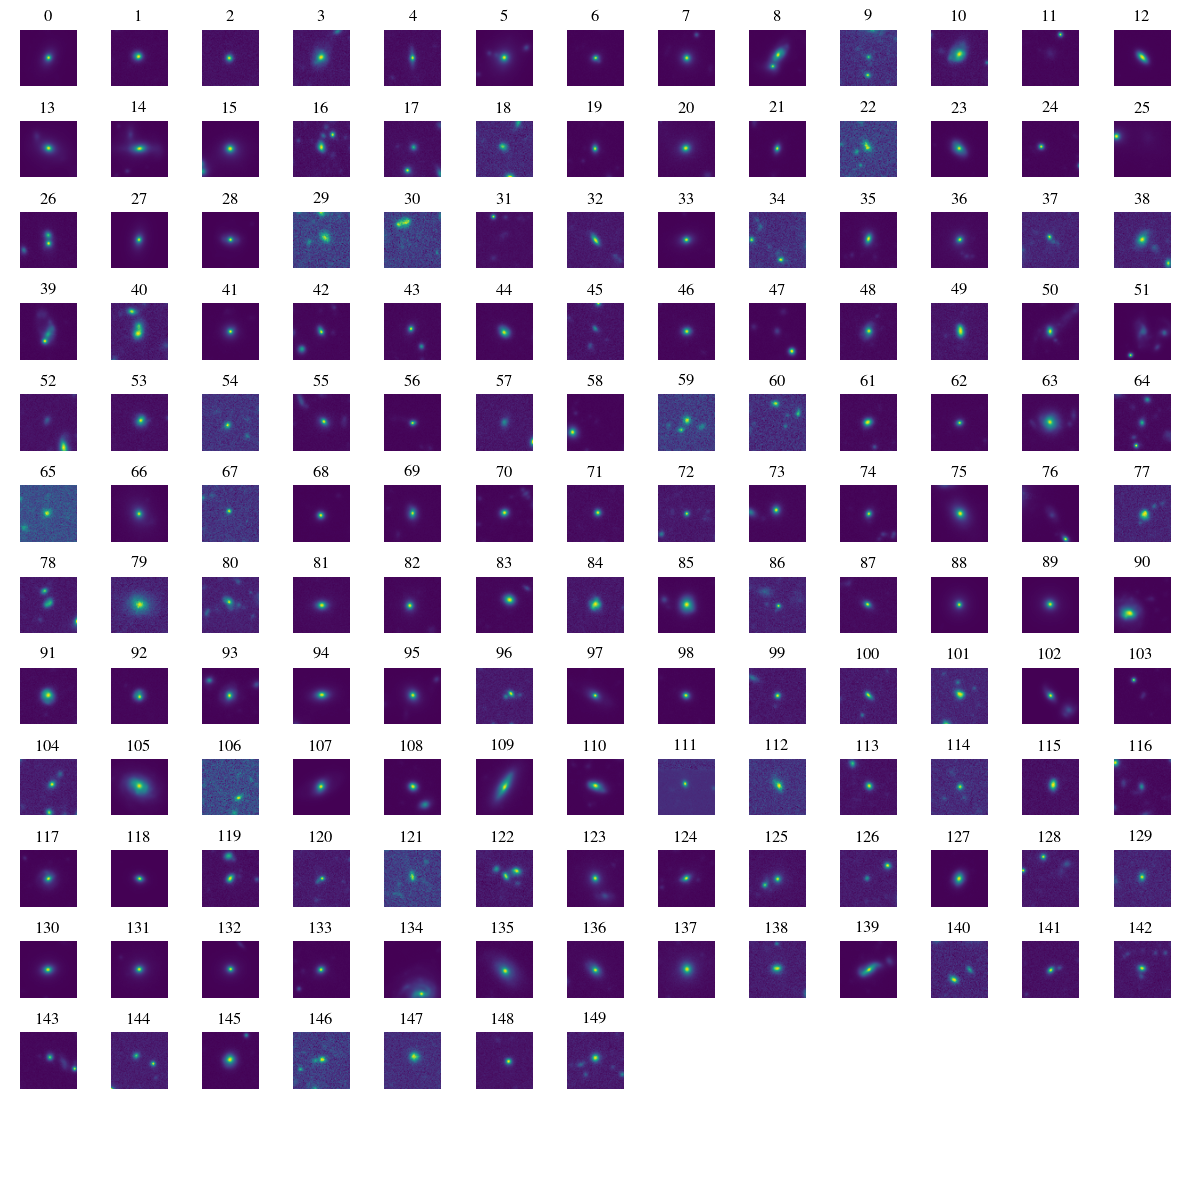

In [6]:
with h5py.File(out_path, "r") as f:
    for k in f.keys():
        print(k, f[k].shape)
            
    cutouts = f['cutouts'][:150]

    display_images(normalize_images(cutouts[:,channel]), vmin=0., vmax=1)

In [5]:
#fn_out = 'HSC_dud_simple_regressor_data_calexp_GIRYZ7610_64.h5'
#fn_in = 'HSC_dud_galaxy_calexp_GIRYZ7610_64_new.h5'
fn_out = 'HSC_dud_simple_regressor_data_GIRYZ7610_64.h5'
fn_in = 'HSC_dud_galaxy_GIRYZ7610_64_new.h5'
num_samples = 6000

with h5py.File(os.path.join(data_dir, fn_out), "w") as f_out:

    cutout_ds = f_out.create_dataset('cutouts', shape=(num_samples,9,64,64))
    zspec_ds = f_out.create_dataset('zspec', shape=(num_samples,))
    ra_ds = f_out.create_dataset('ra', shape=(num_samples,))
    dec_ds = f_out.create_dataset('dec', shape=(num_samples,))

    with h5py.File(os.path.join(data_dir, fn_in), "r") as f:   
    
        zspec = f['zspec'][:]

        # Go through in random order
        indices = np.random.permutation(np.where((zspec>0.2)&(zspec<1.0))[0])

        i_out = 0
        for i_in in indices:
            if i_out>=num_samples:
                break

            cutout = f['cutouts'][i_in]
    
            # Check if bad sample
            if np.any((cutout[:5] < -1) | np.isnan(cutout[:5]) | (cutout[:5] > 200)):
                continue
       
            # Add the new data
            cutout_ds[i_out] = cutout
            zspec_ds[i_out] = f['zspec'][i_in]
            ra_ds[i_out] = f['ra'][i_in]
            dec_ds[i_out] = f['dec'][i_in]
            i_out+=1

cutouts (6000, 9, 64, 64)
dec (6000,)
[ 8.2311076e-01 -4.4487481e+00 -4.0612497e+00  2.9944694e-01
 -6.1371841e-02 -4.4959679e+00  3.1468999e-02 -1.9193981e-02
  9.0076381e-01 -1.2810259e-02  2.8264279e+00  2.9175444e+00
 -6.7871130e-01  2.4379613e+00  2.5344828e-01 -4.2144804e+00
  5.4951633e+01 -4.5293136e+00 -4.2137120e-02  5.4106258e+01
 -8.8841662e-02  1.7851204e-01 -4.4495878e+00 -9.1050833e-02
 -4.3996320e+00  2.4024062e+00  6.1962780e-02 -8.3570831e-02
 -4.3993173e+00  2.9304800e+00  3.5196045e-01  1.9836251e+00
 -3.7791097e+00  1.3425037e+00  6.0854021e-02 -4.3947592e+00
  5.3366669e+01 -2.9008890e-02  5.6059551e+01 -4.5495105e+00
 -4.6895361e+00  2.2450271e+00  2.0042722e-01  4.8357055e-02
  4.1891518e-01 -4.4843054e+00  9.4830833e-02  1.9469084e-01
  3.2545016e+00  6.6391200e-02  1.4542472e+00  5.5923264e+01
  5.3470520e+01  2.4422847e-01  1.8591527e+00  2.1951568e+00
  1.8476630e-02 -4.5088363e+00  5.5467499e+01 -8.5361820e-01
 -4.3360729e+00  7.9841442e-02  1.8620614e-02 -

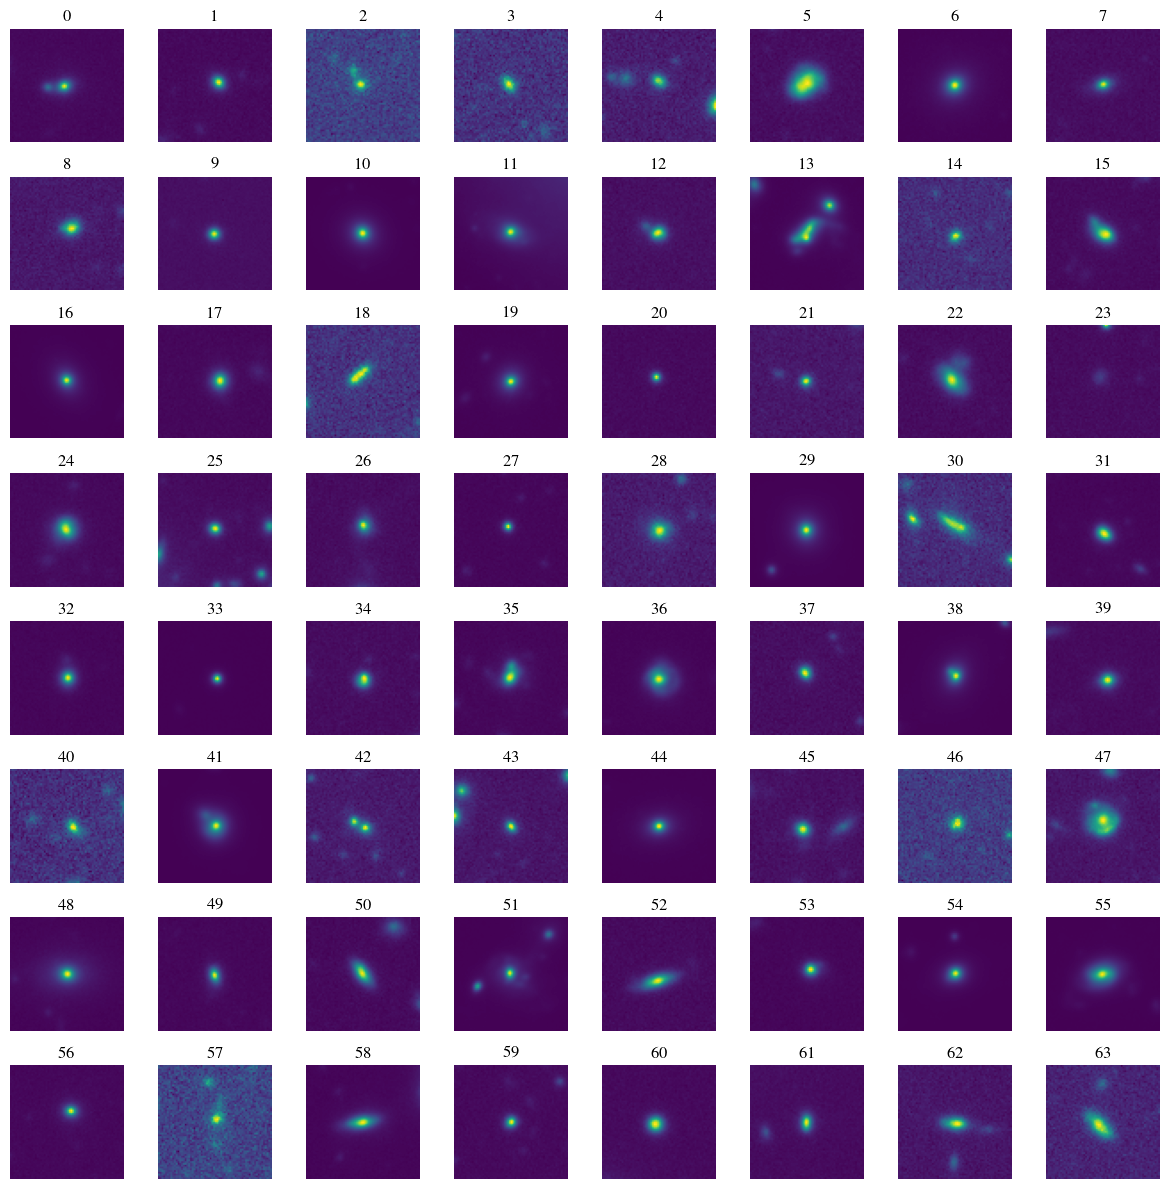

In [6]:
channel = 1

with h5py.File(os.path.join(data_dir, fn_out), "r") as f:   
    for k in f.keys():
        print(k, f[k].shape)
        if 'cutout' in k:
            continue
        else:
            print(f[k][-64:])
        
    cutouts = f['cutouts'][-64:]
    display_images(normalize_images(cutouts[:,channel]), vmin=0., vmax=1)